In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, acf, pacf
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Transforming data to DateTime 

In [2]:
fuelPrice = pd.read_csv('C:/ICUP/InformatiCup2018-master/Eingabedaten/Benzinpreise/1.csv', header = None, delimiter = ';', names = ('Time', 'Price'))
index = pd.DatetimeIndex(fuelPrice.Time)
fuelPrice.drop('Time', axis = 1, inplace = True)
fuelPrice.set_index(index, inplace = True)
fuelPrice = fuelPrice['2016':'2017']

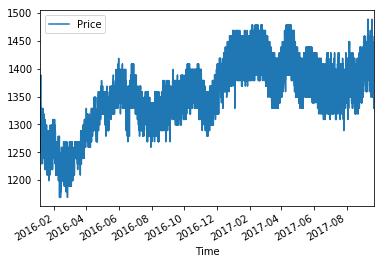

In [3]:
fuelPrice.plot()
plt.show()

# Resampled by week

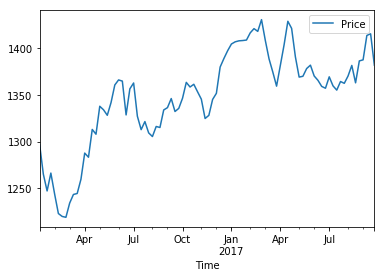

In [4]:
week_fuelPrice = fuelPrice.resample('W').mean()
week_fuelPrice.dropna(inplace = True)
week_fuelPrice.plot()
plt.show()

# Resample by hour

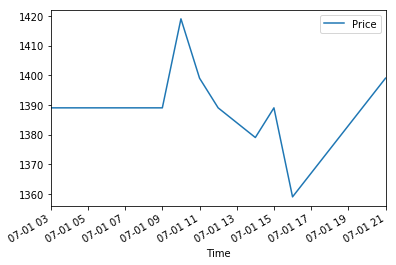

In [34]:
hour_fuelPrice = fuelPrice.resample('H').mean()
hour_fuelPrice.dropna(inplace = True)
hour_fuelPrice['2017-07-01'].plot()
plt.show()

# Check stationarity using augmented Dickey-Fuller test
If test statistic is more than critical value & p-value is larger than 0.05 than time series is NOT stationary.

In [6]:
def adftest(X):
    test = adfuller(X.iloc[:,0].values)

    print('Test Statistic: ',test[0])
    print('p-value: ',test[1])
    print('Lags: ',test[2])
    print('Observation number: ',test[3])
    print('Critical value 1%: ',test[4]['1%'])
    print('Critical value 5%: ',test[4]['5%'])
    print('Critical value 10%: ',test[4]['10%'])
    #print('Test Statistic: {};{}p-value: {};{}Lags: {};{}Observation number: {};'.format(test[0], '\n', test[1], '\n', test[2], '\n', test[3]))
    #print('Critical value 1%: {};{} Critical value 5%: {};{} Critical value 10% : {}'.format(test[4]['1%'], '\n', test[4]['5%'], '\n', test[4]['10%']))
    if (test[0]>test[4]['1%']) & (test[1]>0.05):
        print ('Time series is not stationary.')
    else:
        print('According to ADF time series is stationary.')
    return

In [7]:
adftest(hour_fuelPrice)

Test Statistic:  -2.45282595901
p-value:  0.127378090226
Lags:  24
Observation number:  4203
Critical value 1%:  -3.43190681616
Critical value 5%:  -2.86222791569
Critical value 10%:  -2.56713618328
Time series is not stationary.


# Decompose time series


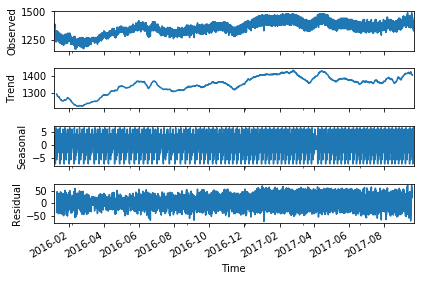

In [8]:
dec = sm.tsa.seasonal_decompose(hour_fuelPrice.interpolate(), freq = 50, model = 'additive')
dec.plot()
plt.show()

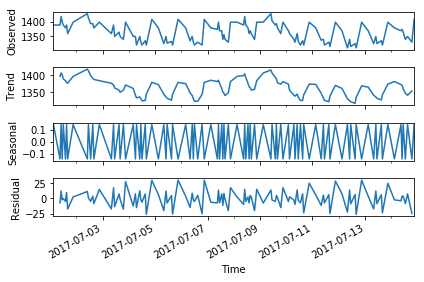

In [37]:
dec2 = sm.tsa.seasonal_decompose(hour_fuelPrice['2017-07-01':'2017-07-14'].interpolate(), freq = 2, model = 'additive')
dec2.plot()
plt.show()

# Plot ACF and PACF

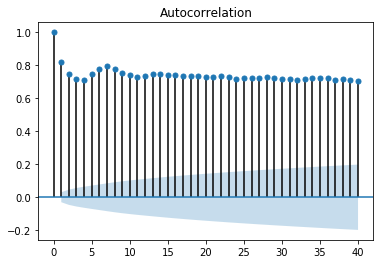

In [10]:
fig = sm.graphics.tsa.plot_acf(hour_fuelPrice, lags = 40)
plt.show()

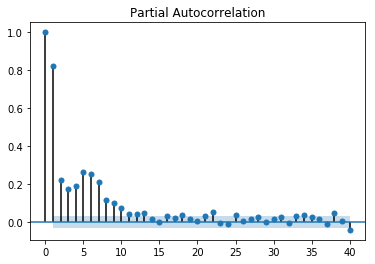

In [11]:
fig = sm.graphics.tsa.plot_pacf(hour_fuelPrice, lags = 40)
plt.show()

# Non-linear log transformation

In [12]:
hour_fuelPrice_log = np.log(hour_fuelPrice)
adftest(hour_fuelPrice_log)

Test Statistic:  -2.41383704115
p-value:  0.137869031146
Lags:  24
Observation number:  4203
Critical value 1%:  -3.43190681616
Critical value 5%:  -2.86222791569
Critical value 10%:  -2.56713618328
Time series is not stationary.


# Plot ACF and PACF

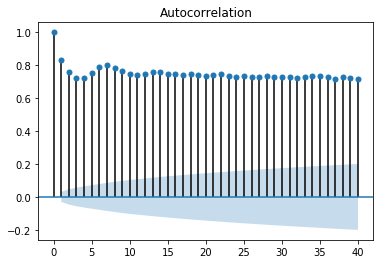

In [13]:
fig = sm.graphics.tsa.plot_acf(hour_fuelPrice_log, lags = 40)
plt.show()

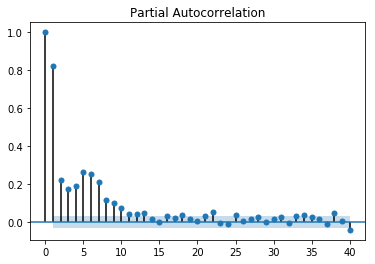

In [14]:
fig = sm.graphics.tsa.plot_pacf(hour_fuelPrice, lags = 40)
plt.show()

# Differencing

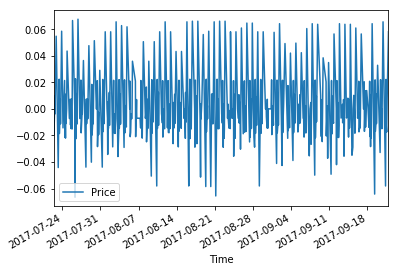

In [15]:
diff = hour_fuelPrice_log - hour_fuelPrice_log.shift()
diff.tail(500).plot()
plt.show()

In [16]:
diff.dropna(inplace = True)
adftest(diff)

Test Statistic:  -16.501281682
p-value:  2.14746181307e-29
Lags:  31
Observation number:  4195
Critical value 1%:  -3.43190978688
Critical value 5%:  -2.86222922803
Critical value 10%:  -2.56713688191
According to ADF time series is stationary.


# Plot ACF and PACF

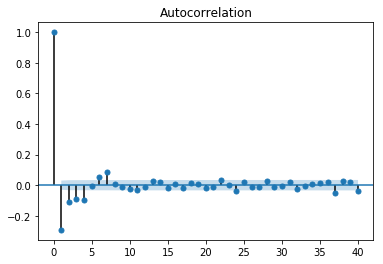

In [17]:
fig = sm.graphics.tsa.plot_acf(diff, lags = 40)
plt.show()

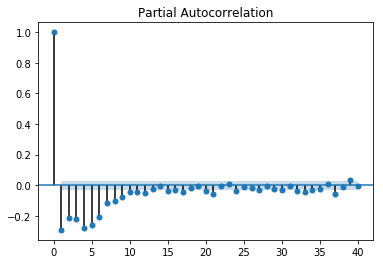

In [18]:
fig = sm.graphics.tsa.plot_pacf(diff, lags = 40)
plt.show()

In [19]:
lag_acf = acf(diff, nlags=10)
lag_pacf = pacf(diff, nlags=10, method='ols')

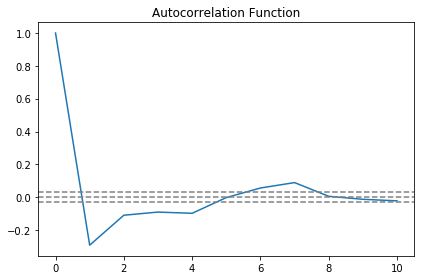

In [20]:
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
plt.tight_layout()
plt.show()

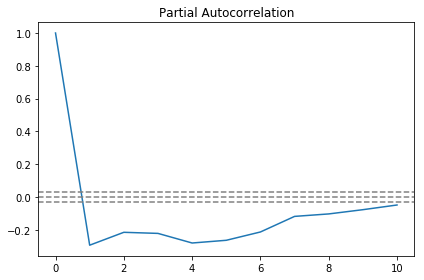

In [21]:
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation')
plt.tight_layout()
plt.show()

 #  Calculate order

In [22]:
res = sm.tsa.arma_order_select_ic(diff, ic=['aic', 'bic'])

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check

In [23]:
res

{'aic':               0             1             2
 0 -19046.473771 -20310.753296 -20647.371686
 1 -19423.027287 -20634.711809 -20652.865564
 2 -19619.468540 -20669.952445 -20751.216271
 3 -19828.773089 -20749.593048 -20800.205577
 4 -20170.043788 -20823.445336 -20827.784260,
 'aic_min_order': (4, 2),
 'bic':               0             1             2
 0 -19033.775275 -20291.705552 -20621.974695
 1 -19403.979544 -20609.314818 -20621.119325
 2 -19594.071549 -20638.206206 -20713.120785
 3 -19797.026850 -20711.497561 -20755.760842
 4 -20131.948301 -20779.000601 -20776.990277,
 'bic_min_order': (4, 1)}

# Model 

In [24]:
mod = ARIMA(hour_fuelPrice_log, order = (4,1,0)).fit(disp = 0, method = 'css')
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Price   No. Observations:                 4227
Model:                 ARIMA(4, 1, 0)   Log Likelihood               10080.854
Method:                           css   S.D. of innovations              0.022
Date:                Tue, 28 Nov 2017   AIC                         -20149.709
Time:                        06:57:11   BIC                         -20111.619
Sample:                    01-06-2016   HQIC                        -20136.244
                         - 09-21-2017                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           5.99e-06      0.000      0.043      0.966      -0.000       0.000
ar.L1.D.Price    -0.4647      0.015    -31.429      0.000      -0.494      -0.436
ar.L2.D.Price    -0.3749      0.016    -24.031      0.000      -0.405      -0.344
ar.L3.D.Price    -0.3338      0.016    -21.396      0.000      -0.364      -0.303
ar.L4.D.Price    -0.2795      0.015    -18.911      0.000      -0.309      -0.251
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.5404           -1.1946j            1.3112           -0.1824
AR.2            0.5404           +1.1946j            1.3112            0.1824
AR.3           -1.1375           -0.8870j            1.4425           -0.3946
AR.4           -1.1375           +0.8870j            1.4425            0.3946
-----------------------------------------------------------------------------
"""

# ARIMA residual density

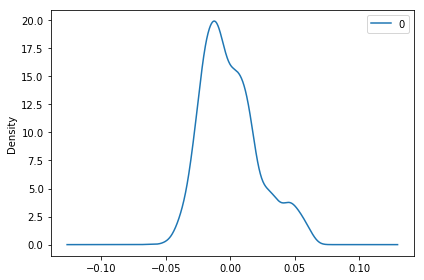

In [25]:
residuals = pd.DataFrame(mod.resid)
residuals.plot(kind='kde')
plt.tight_layout()
plt.show()

In [26]:
residuals.describe()

,0
count,4.223000e+03
mean,1.225574e-08
std,2.223803e-02
min,-6.247033e-02
25%,-1.633598e-02
50%,-3.660866e-03
75%,1.251738e-02
max,6.568157e-02


# In sample predictions

In [27]:
t = hour_fuelPrice_log.as_matrix()
size = int(len(t) - 15)
train,  test = t[0:size], t[size:len(t)]
log = [x for x in train]
predictions = list()
print('Predicted vs Expected:')
for t in range(len(test)):
    mod = ARIMA(log, order = (4,1,0)).fit(disp=0, method = 'css')
    res = mod.forecast()
    yhat = res[0]
    predictions.append(float(yhat))
    obs = test[t]
    log.append(obs)
    print('predicted=%.2f, expected=%.2f' % (np.exp(yhat), np.exp(obs)))


Predicted vs Expected:
predicted=1362.69, expected=1349.00
predicted=1362.29, expected=1394.00
predicted=1378.36, expected=1349.00
predicted=1353.73, expected=1379.00
predicted=1371.13, expected=1364.00
predicted=1362.10, expected=1349.00
predicted=1364.03, expected=1349.00
predicted=1351.22, expected=1329.00
predicted=1347.28, expected=1419.00
predicted=1388.57, expected=1339.00
predicted=1348.93, expected=1369.00
predicted=1360.49, expected=1352.33
predicted=1350.22, expected=1329.00
predicted=1357.96, expected=1339.00
predicted=1340.23, expected=1419.00


# MSE metric 

In [28]:
mean_squared_error(test, predictions)

0.00066207798014501545

# Forecast with ARIMA

In [29]:
H = 20
mod = ARIMA(hour_fuelPrice, order = (4,1,0)).fit(disp=0, method = 'css')
forecasty = mod.forecast(steps = H)
index = pd.date_range(hour_fuelPrice.index[-1], periods = H, freq = 'H')
forecasted_price = pd.DataFrame(forecasty[0], index = index)
hour_fuelPrice = hour_fuelPrice.append(forecasted_price)

In [30]:
print(hour_fuelPrice.tail(H+30))

                           Price            0
2017-09-18 05:00:00  1449.000000          NaN
2017-09-18 07:00:00  1429.000000          NaN
2017-09-18 10:00:00  1459.000000          NaN
2017-09-18 11:00:00  1429.000000          NaN
2017-09-18 13:00:00  1429.000000          NaN
2017-09-18 14:00:00  1389.000000          NaN
2017-09-18 15:00:00  1404.000000          NaN
2017-09-18 16:00:00  1389.000000          NaN
2017-09-18 17:00:00  1359.000000          NaN
2017-09-18 21:00:00  1449.000000          NaN
2017-09-19 08:00:00  1359.000000          NaN
2017-09-19 10:00:00  1389.000000          NaN
2017-09-19 11:00:00  1365.666667          NaN
2017-09-19 13:00:00  1349.000000          NaN
2017-09-19 15:00:00  1364.000000          NaN
2017-09-19 16:00:00  1349.000000          NaN
2017-09-19 21:00:00  1394.000000          NaN
2017-09-20 08:00:00  1349.000000          NaN
2017-09-20 10:00:00  1379.000000          NaN
2017-09-20 11:00:00  1364.000000          NaN
2017-09-20 14:00:00  1349.000000  

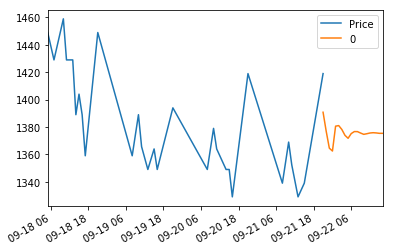

In [31]:
hour_fuelPrice.tail(H+30).plot()
plt.show()